In [24]:
import librosa
import numpy as np
#import pandas as pd
from keras.layers import Dense
from keras.models import Sequential
from pydub import AudioSegment
from scipy import signal
from sklearn import preprocessing
from tensorflow import keras
from matplotlib import pyplot as plt

In [31]:
edge_size

466

In [3]:
pathAudio = '/home/stud/m/mh361/share/samples-stochastic/'
files = librosa.util.find_files(pathAudio, ext=['mp3'])

song_lounge_it = []
song_tuesday_night = []
song_kingtop = []
for file in files:
    if 'Maarten Schellekens - Lounge It' in file:
        song_lounge_it.append(file)
    if 'Maarten Schellekens - Tuesday Night Radio Edit' in file:
        song_tuesday_night.append(file)
    if 'Tea K Pea - kingtop' in file:
        song_kingtop.append(file)
song_lounge_it = sorted(song_lounge_it, key=lambda x: int(x.split('_')[-1].split('.')[0]))
song_tuesday_night = sorted(song_tuesday_night, key=lambda x: int(x.split('_')[-1].split('.')[0]))
song_kingtop = sorted(song_kingtop, key=lambda x: int(x.split('_')[-1].split('.')[0]))

In [4]:
full_songs = []
full_songs.extend(song_lounge_it)
full_songs.extend(song_tuesday_night)
full_songs.extend(song_kingtop)
len(full_songs)

243

In [5]:
def normalize_sample(sample):
    array_of_samples = sample.get_array_of_samples()
    np_arr = np.array(array_of_samples)
    np_arr = np_arr.reshape(1, -1)
    return preprocessing.normalize(np_arr)


samples = []
samples_sec_canal = []
for file_name in full_songs:
    sample = AudioSegment.from_mp3(file_name)
    mono_samples = sample.split_to_mono()
    normalized_sample = normalize_sample(mono_samples[0])[0]
    resampled_sample = signal.resample(normalized_sample, int(len(normalized_sample)/35))
    samples.append(resampled_sample)
    normalized_sample_sec_canal = normalize_sample(mono_samples[1])[0]
    resampled_sample_sec_canal = signal.resample(normalized_sample_sec_canal, int(len(normalized_sample)/35))
    samples_sec_canal.append(resampled_sample_sec_canal)

In [6]:
edge_size = min(map(len, samples))

In [7]:
X_train = []
Y_train = []
for i in range(len(samples)-1):
    Y_train.append(True)
    first_half = list(samples[i][-edge_size:])
    last_half = list(samples[i + 1][:edge_size])
    X_train.append(first_half+last_half)
    if(i < len(samples)-2):
        Y_train.append(True)
        sec_last_half = list(samples[i + 2][:edge_size])
        X_train.append(first_half+sec_last_half)

In [8]:
from numpy import random

def get_strange_end_part(samples, current_index, max_len):
    x = random.randint(max_len-1)
    if (x != current_index+1) and (x != current_index+2):
        return list(samples[x][:edge_size])
    else:
        return get_strange_end_part(samples, current_index, max_len)


for i in range(len(samples)-1):
    first_half = list(samples[i][-edge_size:])
    last_half = get_strange_end_part(samples, i, len(samples))
    X_train.append(first_half+last_half)
    Y_train.append(False)
    sec_last_half = get_strange_end_part(samples, i, len(samples))
    X_train.append(first_half+sec_last_half)
    Y_train.append(False)

In [9]:
X_train = np.array(X_train)
X_train = X_train.reshape(-1, 2*edge_size)
X_train.shape

(967, 932)

In [10]:
Y_train = np.array(Y_train)
Y_train = Y_train.reshape(-1, 1)
Y_train.shape

(967, 1)

In [11]:
model = keras.models.load_model('/home/stud/m/mh361/share/saved-model/Best Model with 1024 filters and LSTM 256 Neurons.h5')

2022-06-26 18:13:59.531313: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-26 18:14:00.055194: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11417 MB memory:  -> device: 0, name: TITAN Xp, pci bus id: 0000:05:00.0, compute capability: 6.1


In [131]:
from keras.layers import Conv1D, LSTM, Flatten, CuDNNLSTM, MaxPool1D, Dropout
from tensorflow.keras.optimizers import SGD

#model = keras.models.load_model('path/to/location')


model = Sequential()
model.add(Conv1D(filters=1024, kernel_size=2, input_shape=(2*edge_size, 1)))
model.add(MaxPool1D(pool_size=2, strides=2))
model.add(CuDNNLSTM(256, return_sequences=True))
model.add(Dense(256))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_17 (Conv1D)          (None, 931, 1024)         3072      
                                                                 
 max_pooling1d_17 (MaxPoolin  (None, 465, 1024)        0         
 g1D)                                                            
                                                                 
 cu_dnnlstm_17 (CuDNNLSTM)   (None, 465, 256)          1312768   
                                                                 
 dense_32 (Dense)            (None, 465, 256)          65792     
                                                                 
 dropout_4 (Dropout)         (None, 465, 256)          0         
                                                                 
 flatten_15 (Flatten)        (None, 119040)            0         
                                                     

In [ ]:
#callback = keras.callbacks.EarlyStopping(monitor='loss', patience=30)
#callback = keras.callbacks.EarlyStopping(monitor='accuracy', baseline=0.9)
    
#monitor ="val_loss", mode ="min", patience = 30, restore_best_weights = True)
    
#monitor='loss', mode='min', verbose=1, patience=75)
#model.fit(X_train, Y_train, epochs=900, validation_split=0.1, batch_size=64, callbacks=callback)

model.fit(X_train, Y_train, epochs=600, batch_size=64)

# Calling `save('my_model.h5')` creates a h5 file `my_model.h5`.
model.save('/home/stud/m/mh361/share/saved-model/binary_model.h5')
print("Saved model to disk")

# batch size 8
#3s 21ms/step - loss: 0.6818 - accuracy: 0.5719
# 3s 21ms/step - loss: 0.7044 - accuracy: 0.5729
# 3s 21ms/step - loss: 0.6933 - accuracy: 0.4747
# 2s 17ms/step - loss: 0.6923 - accuracy: 0.5574
# 3s 29ms/step - loss: 0.6837 - accuracy: 0.5667
#121/121 [==============================] - 4s 30ms/step - loss: 0.6872 - accuracy: 0.5595 filters 512 , lstm 512

#batch size 64
# 2s 117ms/step - loss: 0.6428 - accuracy: 0.5957
#16/16 [==============================] - 2s 114ms/step - loss: 0.6905 - accuracy: 0.5522 -> kernel 4 lstm 512
# 16/16 [==============================] - 2s 115ms/step - loss: 0.6914 - accuracy: 0.5429 kernel 3 lstm 512
# 16/16 [==============================] - 2s 134ms/step - loss: 0.6446 - accuracy: 0.6070 kernel 2 lstm 512 filters 512
# Epoch 1000/1000
# 16/16 [==============================] - 2s 131ms/step - loss: 0.5504 - accuracy: 0.6856

#batch size 32
#  1s 46ms/step - loss: 0.7023 - accuracy: 0.5553

#batch size 128
#1s 92ms/step - loss: 0.6887 - accuracy: 0.5346



In [22]:
example_x_train = X_train[7]
example_x_train = example_x_train.reshape(1, 2*edge_size)
pred = model.predict(example_x_train)
print('Gutes Sample')
pred[0][0]


Gutes Sample


0.9886544

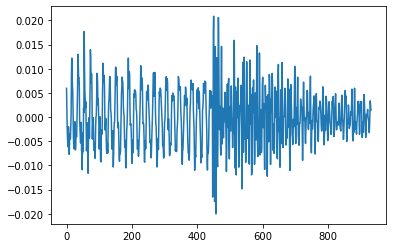

In [26]:
plt.plot(X_train[7])
plt.show()

In [14]:
example_x_train = X_train[-3]
example_x_train = example_x_train.reshape(1, 2*edge_size)
pred = model.predict(example_x_train) 
print('Schlechtes Sample')
pred[0][0]

Schlechtes Sample


0.006978564

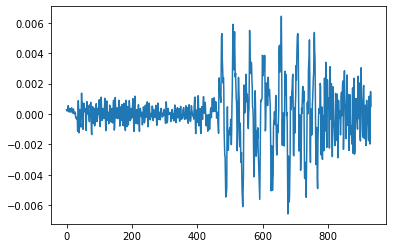

In [30]:
plt.plot(X_train[-1])
plt.show()

In [ ]:
#Forschungsfragen
#› Lässt sich ein „hörbarer“ Musikstream erzeugen?
#› Reicht das stochastische Sampling? Wie lange ist eine optimale Sampledauer?
#› Wie ähnlich müssen sich die Urspungstracks bezüglich Stimmung, Genre, etc sein?
#› Müssen Metadaten wie Lautstärke, Tempo, Spektrum, etc mit einbezogen werden?

In [ ]:
from pathlib import Path

path_all_samples = '/home/stud/m/mh361/share/sample-pool/'
sample_files = librosa.util.find_files(path_all_samples, ext=['mp3'])
loaded_samples = {}
for file_path in sample_files:
    loaded_audio_file = AudioSegment.from_mp3(file_path)
    sample_array = loaded_audio_file.get_array_of_samples()
    resampled_part = signal.resample(sample_array, int(len(normalized_sample)/35))
    if len(resampled_part) >= edge_size:
        file_name = Path(file_path).stem
        loaded_samples[file_name] = resampled_part

In [ ]:
#loaded_samples

In [ ]:
list(loaded_samples.keys())[1273][:-4]

In [ ]:
start_sample_name = list(loaded_samples.keys())[1273]

In [ ]:
reference_sample = loaded_samples[start_sample_name]
reference_sample

In [ ]:
len(reference_sample)

In [ ]:
'Brylie Christopher Oxley - City view from Torni_119'

In [ ]:
i = 0
max = 100
selected_samples = [start_sample_name]
song_counter = [start_sample_name, 0]
song_blacklist = []
while i < max:
    best_sample_name = None
    best_score = 0.00000
    best_sample = []
    for key, value in loaded_samples.items():
        if (key not in selected_samples) and (key[:-4] not in song_blacklist):
            ref_and_sample = np.append(reference_sample[-edge_size:], value[:edge_size])
            prediction = model.predict(ref_and_sample.reshape(1, 932))
            score = prediction[0][0]
            if score > best_score:
                best_score = score
                best_sample_name = key
                best_sample = value
            if score > 0.99:
                break
    print('Predicted ' + best_sample_name + ' at position ' + str(i) + ' as best sample with score ' + str(
        best_score))
    reference_sample = best_sample
    selected_samples.append(best_sample_name)
    if song_counter[0] in best_sample_name:
        song_counter[1] = song_counter[1]+1
    else:
        song_counter[0] = best_sample_name[:-4]
        song_counter[1] = 0
    if song_counter[1] >= 2:
        song_blacklist.append(best_sample_name[:-4])
    if len(song_blacklist) >= 3:
        song_blacklist = song_blacklist[1:]
    i += 1
    #print(song_counter)
    #if i > 1:
    #    break

In [ ]:
i = 0
max = 100
selected_samples = [start_sample_name]
while i < max:
    best_sample_name = None
    best_score = 0.00000
    best_sample = []
    for key, value in loaded_samples.items():
        if key not in selected_samples:
            ref_and_sample = np.append(reference_sample[-edge_size:], value[:edge_size])
            prediction = model.predict(ref_and_sample.reshape(1, 932))
            score = prediction[0][0]
            if score > best_score:
                best_score = score
                best_sample_name = key
                best_sample = value
            if score > 0.99:
                break
    print('Predicted ' + best_sample_name + ' at position ' + str(i) + ' as best sample with score ' + str(
        best_score))
    reference_sample = best_sample
    selected_samples.append(best_sample_name)
    i += 1

In [ ]:
new_song = AudioSegment.empty()
for sample in selected_samples:
    complete_path = '/home/stud/m/mh361/share/sample-pool/' + sample + '.mp3'
    loaded_sample = AudioSegment.from_mp3(complete_path)
    new_song += loaded_sample
new_song.export('/home/stud/m/mh361/share/music-out/' + 'karacho_2.mp3', format='mp3')

In [ ]:
new_song

In [ ]:
from keras.callbacks import Callback

class TerminateOnBaseline(Callback):
    """
    Callback that terminates training when either acc or val_acc reaches a specified
    baseline after a specified number of epochs
    """
    def __init__(self, monitor='accuracy', baseline=0.9, n_epochs=40):
        super(TerminateOnBaseline, self).__init__()
        self.monitor = monitor
        self.baseline = baseline
        self.n_epochs = n_epochs

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        acc = logs.get(self.monitor)
        if acc is not None:
            if acc < self.baseline and epoch >= self.n_epochs:
                print('Epoch %d: Accuracy has not reached the baseline, terminating training' % (epoch))
                self.model.stop_training = True